In [266]:
import os
import warnings
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
from skimage import io, transform
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils, models
from sklearn.metrics import average_precision_score

warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

from src.dataset import NodulesDataset
from src.augmentations import create_mip
from src.custom_models import resnet2d

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load molel

In [304]:
# model = resnet.resnet18()
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, 2)

# model_ft = resnet.resnet18()

model = resnet2d.resnet18without_batch_norm()

save_path = "models/resnet18_2021-04-03_03:04:07.pt"
# save_path = "models/resnet18_2021-03-29_16:42:26.pt"
model.load_state_dict(torch.load(save_path))
model.eval()

# model.apply(deactivate_batchnorm)

### Analyze

In [305]:
original_dataset_without_augmentations = NodulesDataset(
    "data/nodules", 
    transform=transforms.Compose(
        [
#             lambda x: x / 255,
#             lambda x: (x - 0.3011869) / 0.25784153,
#             lambda x: x[np.newaxis, :, :, :],
#             lambda x: torch.tensor(x, dtype=torch.float32),
            
            lambda x: create_mip(x),
            lambda x: x/255,
            lambda x: x[np.newaxis, :, :],
            lambda x: torch.tensor(x, dtype=torch.float32),
        ]
    ),
    return_path = True
)

original_loader = torch.utils.data.DataLoader(
    original_dataset_without_augmentations, batch_size=32, shuffle=False, num_workers=1
)

In [306]:
results = []
with torch.no_grad():
    for i, (input_, label, path) in tqdm(enumerate(original_dataset_without_augmentations), total=len(original_dataset_without_augmentations)):
        output = model(input_.unsqueeze(0))

        _, pred = torch.max(output, 1)

        results.append({
            "id": i,
            "path": path,
            "prob": output.numpy()[0][1],
            "y_pred": pred.numpy()[0],
            "y_true": label,
        })

100%|██████████| 837/837 [00:07<00:00, 117.45it/s]


In [307]:
results = pd.DataFrame(results)

In [308]:
results

,id,path,prob,y_pred,y_true
0,0,data/nodules/0.npy,9.999994e-01,1,1
1,1,data/nodules/1.npy,1.000000e+00,1,1
2,2,data/nodules/2.npy,1.000000e+00,1,1
3,3,data/nodules/3.npy,7.544343e-37,0,0
4,4,data/nodules/4.npy,6.598618e-01,1,1
...,...,...,...,...,...
832,832,data/nodules/832.npy,4.661128e-29,0,0
833,833,data/nodules/833.npy,1.000000e+00,1,1
834,834,data/nodules/834.npy,1.000000e+00,1,1
835,835,data/nodules/835.npy,1.000000e+00,1,1


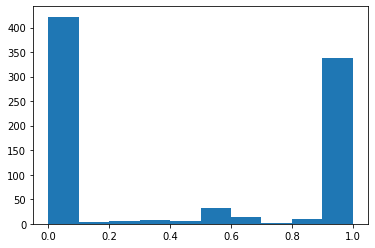

In [309]:
plt.hist(results["prob"])
plt.show()

In [310]:
# results[np.array([results["prob"] < 0.3, results["prob"] > 0.25]).all(axis=0)]
results[np.array([results["prob"] < 0.8, results["prob"] > 0.7]).all(axis=0)]

,id,path,prob,y_pred,y_true
22,22,data/nodules/22.npy,0.728199,1,0
422,422,data/nodules/422.npy,0.765127,1,1


In [275]:
results[results["y_pred"] != results["y_true"]]

,id,path,prob,y_pred,y_true
11,11,data/nodules/11.npy,3.581552e-02,0,1
22,22,data/nodules/22.npy,9.805504e-01,1,0
30,30,data/nodules/30.npy,9.314186e-19,0,1
38,38,data/nodules/38.npy,9.999993e-01,1,0
39,39,data/nodules/39.npy,8.644773e-01,1,0
...,...,...,...,...,...
785,785,data/nodules/785.npy,5.816640e-08,0,1
790,790,data/nodules/790.npy,6.000522e-01,1,0
801,801,data/nodules/801.npy,6.007463e-01,1,0
810,810,data/nodules/810.npy,5.828556e-01,1,0


### Find AE

In [314]:
ae_id = 422

(-0.5, 47.5, 47.5, -0.5)

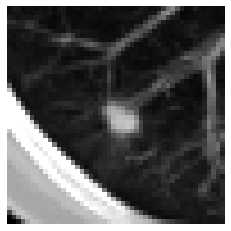

In [315]:
plt.imshow(original_dataset_without_augmentations[ae_id][0][0].numpy(), cmap="gray")
plt.axis('off')

In [290]:
original_dataset_with_noise = NodulesDataset(
    "data/nodules", 
    transform=transforms.Compose(
        [
#             lambda x: x/255,
#             lambda x: (x - 0.3011869) / 0.25784153,
#             lambda x: x + np.random.normal(0,0.04,(48, 48, 48)),
#             lambda x: x[np.newaxis, :, :, :],
#             lambda x: torch.tensor(x, dtype=torch.float32),
            
            lambda x: create_mip(x),
            lambda x: x/255,
            lambda x: x + np.random.normal(0,0.02,(48, 48)),
            lambda x: x[np.newaxis, :, :],
            lambda x: torch.tensor(x, dtype=torch.float32),
        ]
        
    ),
    return_path = True
)

(-0.5, 47.5, 47.5, -0.5)

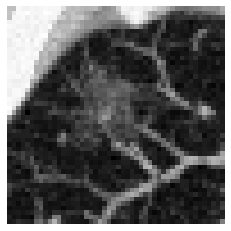

In [291]:
plt.imshow(original_dataset_with_noise[ae_id][0][0].numpy(), cmap="gray")
plt.axis('off')

In [295]:
import itertools
ae = []
for _ in tqdm(range(10000)):
    input_, label, path = original_dataset_with_noise[ae_id]
    output = model(input_.unsqueeze(0))
    
    _, pred = torch.max(output, 1)
        
    ae.append(
        {
            "prob": output.detach().numpy()[0][1],
#             "image": input_.detach().numpy() if output.detach().numpy()[0][1] <= 0.5 else None,
            "image": input_.detach().numpy() if output.detach().numpy()[0][1] <= 0.5 else None,
        }
    )

100%|██████████| 10000/10000 [01:29<00:00, 111.88it/s]


In [296]:
probs = pd.DataFrame([x["prob"] for x in ae])

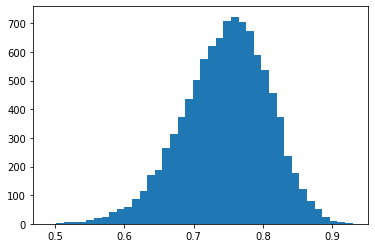

In [297]:
plt.hist(probs[0].to_numpy(), bins=40)
plt.show()

In [301]:
probs[probs[0] <= 0.5].shape

(1, 1)

(-0.5, 47.5, 47.5, -0.5)

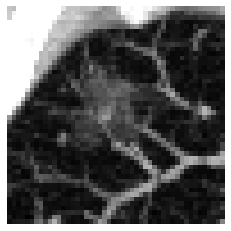

In [302]:
plt.imshow(original_dataset_without_augmentations[ae_id][0][0], cmap="gray")
plt.axis('off')

IndexError: index 1 is out of bounds for axis 0 with size 1

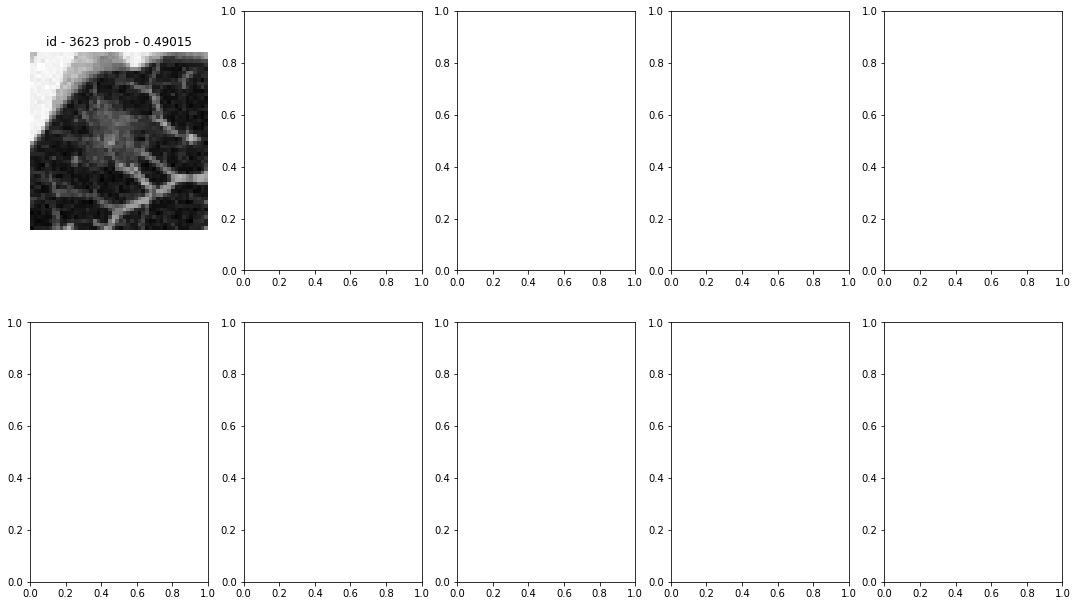

In [303]:
columns = 5
rows = 2
f, ax = plt.subplots(rows, columns)
f.set_size_inches(18.5, 10.5)
for i in range(rows):
    for j in range(columns):
        id_ = probs[probs[0] <= 0.5].index[i*rows+j]
        ax[i, j].set_title(f"id - {id_} prob - {str(round(ae[id_]['prob'], 5))}")
        ax[i, j].imshow(ae[id_]["image"][0], cmap="gray")
        ax[i, j].axis('off')

In [300]:
from scipy.spatial.distance import euclidean

In [74]:
original_dataset_without_augmentations[ae_id][0][0].numpy().shape

(48, 48)

In [75]:
probs[probs[0] < 0.5][0].index[0]

27

In [76]:
ae[probs[probs[0] < 0.5][0].index[0]]["image"][0].shape

(48, 48)

In [77]:
np.linalg.norm(original_dataset_without_augmentations[ae_id][0][0].numpy() - ae[probs[probs[0] < 0.5][0].index[0]]["image"][0])

0.9404681

In [78]:
np.linalg.norm(original_dataset_without_augmentations[ae_id][0][0].numpy() - original_dataset_without_augmentations[ae_id][0][0].numpy())

0.0